## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,
                                     Add, Activation, GlobalAveragePooling1D, LayerNormalization,
                                     MultiHeadAttention, Dropout as KDropout,
                                     GRU, Bidirectional)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## Data Preparation : Load and Combine Data

In [3]:
# Configs
DATA_PATH = 'G:/Capstone data/karsl-502'
LABELS_PATH = 'G:/Capstone data/KARSL-502_Labels.xlsx'
F_AVG = 30
NUM_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 12

In [4]:
# Load labels
df_labels = pd.read_excel(LABELS_PATH)
w2id = dict(zip(df_labels['Sign-Arabic'], df_labels['SignID']))
words = list(w2id.keys())
label_map = {word: idx for idx, word in enumerate(words)}
NUM_CLASSES = len(words)

In [5]:
def preprocess_data(data_path, signers, split, f_avg):
    sequences = []
    labels = []
    for word in tqdm(words, desc=f'Loading {split} data for signers {signers}'):
        for signer in signers:
            word_id = w2id[word]
            keypoints_dir = os.path.join(data_path, signer, split, str(word_id).zfill(4))

            required_dirs = ['lh_keypoints', 'rh_keypoints', 'pose_keypoints']
            if not all(os.path.exists(os.path.join(keypoints_dir, d)) for d in required_dirs):
                continue

            lh_dir = os.path.join(keypoints_dir, 'lh_keypoints')
            for sequence in os.listdir(lh_dir):
                try:
                    lh = np.load(os.path.join(lh_dir, sequence))
                    rh = np.load(os.path.join(keypoints_dir, 'rh_keypoints', sequence))
                    pose = np.load(os.path.join(keypoints_dir, 'pose_keypoints', sequence))

                    def pad_sequence(seq):
                        if len(seq) < f_avg:
                            pad = np.tile(seq[-1], (f_avg - len(seq), 1))
                            return np.concatenate([seq, pad])
                        return seq[:f_avg]

                    lh = pad_sequence(lh)
                    rh = pad_sequence(rh)
                    pose = pad_sequence(pose)

                    # Combine pose, lh, rh on last axis (features)
                    combined = np.concatenate([pose, lh, rh], axis=-1)  # shape (f_avg, features)
                    sequences.append(combined)
                    labels.append(label_map[word])
                except Exception as e:
                    print(f"Error loading {sequence}: {e}")

    X = np.array(sequences)
    y = to_categorical(labels, num_classes=NUM_CLASSES)

    return X, y

In [6]:
# Load train and test data
X_train, y_train = preprocess_data(DATA_PATH, ['01', '02','03'], 'train', F_AVG)
X_test, y_test = preprocess_data(DATA_PATH, ['01', '02','03'], 'test', F_AVG)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Loading train data for signers ['01', '02', '03']: 100%|█████████████████████████████| 502/502 [22:47<00:00,  2.72s/it]
Loading test data for signers ['01', '02', '03']: 100%|██████████████████████████████| 502/502 [04:23<00:00,  1.90it/s]


Shapes:
X_train: (58529, 30, 225) y_train: (58529, 502)
X_test: (11110, 30, 225) y_test: (11110, 502)


## Data Augmentation 

In [8]:
'''
Explanation:
 Data augmentation artificially increases training data diversity by applying random
 transformations or noise. Here, adding noise helps model learn robustness against slight variations.
 Since your data are numerical sequences (keypoints), noise injection is an appropriate simple augmentation.
 More complex augmentations like temporal warping or jittering could be considered for further improvement.
'''

'\nExplanation:\n Data augmentation artificially increases training data diversity by applying random\n transformations or noise. Here, adding noise helps model learn robustness against slight variations.\n Since your data are numerical sequences (keypoints), noise injection is an appropriate simple augmentation.\n More complex augmentations like temporal warping or jittering could be considered for further improvement.\n'

In [9]:
def augment_data(X, noise_level=0.01):
    """
    Adds Gaussian noise to training data to improve model generalization by
    simulating small variations and reducing overfitting.
    """
    noise = noise_level * np.random.randn(*X.shape)
    return X + noise

## Models

### CNN model

In [12]:
def build_cnn_model(input_shape, num_classes):
    """
    CNN model for sequence classification:
    - Two Conv1D layers with Batch Normalization and ReLU activations.
    - MaxPooling layers to reduce temporal dimension.
    - Dense layer with BatchNorm and Dropout before final classification.
    """
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)  # Slightly increased dropout
    
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='CNN')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### ViT model

In [14]:
# (Patch embedding + transformer encoder)

In [15]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = KDropout(rate)
        
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.dropout2 = KDropout(rate)
        
    def call(self, inputs, training=False):
        # PreNorm style
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, x_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        out_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = Dense(embed_dim)
        self.position_embedding = self.add_weight(name="pos_embed", shape=(1, num_patches, embed_dim))
    def call(self, patch):
        x = self.projection(patch)
        return x + self.position_embedding

In [16]:
def build_vit_model(input_shape, num_classes, embed_dim=96, num_heads=6, ff_dim=192, num_layers=3, dropout=0.15):
    """
    (ViT) model for sequence classification:
    - Patch embedding with dense projection and learned positional embeddings.
    - Multiple Transformer blocks with Multi-Head Attention and Feed-Forward layers.
    - Pre-LayerNorm before attention and feed-forward sublayers.
    - Global average pooling followed by dropout and final classification layer.
    """
    inputs = Input(shape=input_shape)
    x = PatchEmbedding(input_shape[0], embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x)
    x = GlobalAveragePooling1D()(x)
    x = KDropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='ViT_Enhanced')
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### GRU model

In [18]:
def build_gru_model(input_shape, num_classes):
    """
    Three-layer GRU model for sequence classification:
    - Three GRU layers with dropout for temporal feature extraction.
    - Final Dense softmax layer for classification.
    """
    inputs = Input(shape=input_shape)
    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = GRU(128)(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='GRU_3Layer')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Training and evaluation

In [20]:
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, NUM_FOLDS=5, EPOCHS=10, BATCH_SIZE=32):
    builders = {
        'CNN': build_cnn_model,
        'ViT': build_vit_model,
        'GRU': build_gru_model  # Replaced BiT with GRU here
    }
    build_fn = builders[model_name]

    input_shape = X_train.shape[1:]
    y_int = np.argmax(y_train, axis=1)

    results = {k: [] for k in ['train_acc', 'val_acc', 'test_acc', 'train_loss', 'val_loss', 'test_loss']}
    best_test_acc = 0
    best_model_path = None

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_num = 1

    for train_idx, val_idx in skf.split(X_train, y_int):
        print(f"\nTraining fold {fold_num} / {NUM_FOLDS} for {model_name}")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Data augmentation on training only
        X_tr_aug = augment_data(X_tr)

        model = build_fn(input_shape, y_train.shape[1])
        if fold_num == 1:
            model.summary()

        checkpoint_path = f"{model_name}_fold{fold_num}.h5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

        history = model.fit(
            X_tr_aug, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[checkpoint, early_stop],
            verbose=2
        )

        train_loss, train_acc = model.evaluate(X_tr, y_tr, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        print(f"Fold {fold_num} results: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        results['test_acc'].append(test_acc)
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['test_loss'].append(test_loss)

        if val_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_path = checkpoint_path

        fold_num += 1

    print(f"\nBest Test accuracy: {best_test_acc:.4f} from model: {best_model_path}")

    return results, best_model_path

### Train CNN

In [21]:
cnn_results, cnn_best_model = train_and_evaluate_model('CNN', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for CNN


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 30, 64)              │          43,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 15, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         229,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 502)                 │         129,014 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 428,406 (1.63 MB)

 Trainable params: 427,510 (1.63 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.79874, saving model to CNN_fold1.h5


1464/1464 - 12s - 8ms/step - accuracy: 0.5551 - loss: 1.9710 - val_accuracy: 0.7987 - val_loss: 0.7024
Epoch 2/12

Epoch 2: val_accuracy improved from 0.79874 to 0.86545, saving model to CNN_fold1.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8434 - loss: 0.5320 - val_accuracy: 0.8655 - val_loss: 0.4327
Epoch 3/12

Epoch 3: val_accuracy improved from 0.86545 to 0.91526, saving model to CNN_fold1.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8913 - loss: 0.3565 - val_accuracy: 0.9153 - val_loss: 0.2780
Epoch 4/12

Epoch 4: val_accuracy did not improve from 0.91526
1464/1464 - 9s - 6ms/step - accuracy: 0.9115 - loss: 0.2777 - val_accuracy: 0.8383 - val_loss: 0.5556
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.91526
1464/1464 - 9s - 6ms/step - accuracy: 0.9245 - loss: 0.2348 - val_accuracy: 0.9081 - val_loss: 0.2886
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.91526
1464/1464 - 9s - 6ms/step - accuracy: 0.9354 - loss: 0.1966 - val_accuracy: 0.9066 - val_loss: 0.3085
Fold 1 results: train_acc=0.9315, val_acc=0.9153, test_acc=0.9179

Training fold 2 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.73894, saving model to CNN_fold2.h5


1464/1464 - 12s - 8ms/step - accuracy: 0.5483 - loss: 1.9976 - val_accuracy: 0.7389 - val_loss: 0.9521
Epoch 2/12

Epoch 2: val_accuracy improved from 0.73894 to 0.80728, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8420 - loss: 0.5378 - val_accuracy: 0.8073 - val_loss: 0.6421
Epoch 3/12

Epoch 3: val_accuracy improved from 0.80728 to 0.84435, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8906 - loss: 0.3546 - val_accuracy: 0.8444 - val_loss: 0.5033
Epoch 4/12

Epoch 4: val_accuracy improved from 0.84435 to 0.87280, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9121 - loss: 0.2784 - val_accuracy: 0.8728 - val_loss: 0.4227
Epoch 5/12

Epoch 5: val_accuracy improved from 0.87280 to 0.94755, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9262 - loss: 0.2335 - val_accuracy: 0.9475 - val_loss: 0.1636
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.94755
1464/1464 - 9s - 6ms/step - accuracy: 0.9346 - loss: 0.2021 - val_accuracy: 0.9318 - val_loss: 0.2252
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.94755
1464/1464 - 9s - 6ms/step - accuracy: 0.9420 - loss: 0.1800 - val_accuracy: 0.9166 - val_loss: 0.2679
Epoch 8/12

Epoch 8: val_accuracy improved from 0.94755 to 0.95276, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9455 - loss: 0.1652 - val_accuracy: 0.9528 - val_loss: 0.1634
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.95276
1464/1464 - 9s - 6ms/step - accuracy: 0.9527 - loss: 0.1465 - val_accuracy: 0.9426 - val_loss: 0.1895
Epoch 10/12

Epoch 10: val_accuracy improved from 0.95276 to 0.95686, saving model to CNN_fold2.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9549 - loss: 0.1353 - val_accuracy: 0.9569 - val_loss: 0.1419
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.95686
1464/1464 - 9s - 6ms/step - accuracy: 0.9566 - loss: 0.1308 - val_accuracy: 0.9527 - val_loss: 0.1655
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.95686
1464/1464 - 9s - 6ms/step - accuracy: 0.9610 - loss: 0.1180 - val_accuracy: 0.9249 - val_loss: 0.2426
Fold 2 results: train_acc=0.9695, val_acc=0.9569, test_acc=0.9545

Training fold 3 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.79925, saving model to CNN_fold3.h5


1464/1464 - 12s - 8ms/step - accuracy: 0.5558 - loss: 1.9886 - val_accuracy: 0.7992 - val_loss: 0.7193
Epoch 2/12

Epoch 2: val_accuracy improved from 0.79925 to 0.90014, saving model to CNN_fold3.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8433 - loss: 0.5329 - val_accuracy: 0.9001 - val_loss: 0.3431
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.90014
1464/1464 - 9s - 6ms/step - accuracy: 0.8926 - loss: 0.3508 - val_accuracy: 0.8951 - val_loss: 0.3457
Epoch 4/12

Epoch 4: val_accuracy improved from 0.90014 to 0.91722, saving model to CNN_fold3.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9120 - loss: 0.2807 - val_accuracy: 0.9172 - val_loss: 0.2685
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.91722
1464/1464 - 9s - 6ms/step - accuracy: 0.9269 - loss: 0.2287 - val_accuracy: 0.7734 - val_loss: 0.8606
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.91722
1464/1464 - 9s - 6ms/step - accuracy: 0.9321 - loss: 0.2058 - val_accuracy: 0.8889 - val_loss: 0.3769
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.91722
1464/1464 - 9s - 6ms/step - accuracy: 0.9419 - loss: 0.1776 - val_accuracy: 0.9143 - val_loss: 0.2711
Fold 3 results: train_acc=0.9289, val_acc=0.9172, test_acc=0.9123

Training fold 4 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.78225, saving model to CNN_fold4.h5


1464/1464 - 12s - 9ms/step - accuracy: 0.5457 - loss: 2.0010 - val_accuracy: 0.7822 - val_loss: 0.7573
Epoch 2/12

Epoch 2: val_accuracy improved from 0.78225 to 0.86349, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8396 - loss: 0.5395 - val_accuracy: 0.8635 - val_loss: 0.4472
Epoch 3/12

Epoch 3: val_accuracy improved from 0.86349 to 0.87297, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8898 - loss: 0.3563 - val_accuracy: 0.8730 - val_loss: 0.4082
Epoch 4/12

Epoch 4: val_accuracy improved from 0.87297 to 0.93909, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9134 - loss: 0.2769 - val_accuracy: 0.9391 - val_loss: 0.1985
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.93909
1464/1464 - 9s - 6ms/step - accuracy: 0.9220 - loss: 0.2406 - val_accuracy: 0.9300 - val_loss: 0.2195
Epoch 6/12

Epoch 6: val_accuracy improved from 0.93909 to 0.94430, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9340 - loss: 0.2043 - val_accuracy: 0.9443 - val_loss: 0.1813
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.94430
1464/1464 - 9s - 6ms/step - accuracy: 0.9402 - loss: 0.1827 - val_accuracy: 0.8548 - val_loss: 0.4984
Epoch 8/12

Epoch 8: val_accuracy improved from 0.94430 to 0.96241, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9444 - loss: 0.1678 - val_accuracy: 0.9624 - val_loss: 0.1189
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.96241
1464/1464 - 9s - 6ms/step - accuracy: 0.9506 - loss: 0.1501 - val_accuracy: 0.9379 - val_loss: 0.1971
Epoch 10/12

Epoch 10: val_accuracy improved from 0.96241 to 0.96745, saving model to CNN_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9531 - loss: 0.1399 - val_accuracy: 0.9675 - val_loss: 0.1060
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.96745
1464/1464 - 9s - 6ms/step - accuracy: 0.9575 - loss: 0.1245 - val_accuracy: 0.9477 - val_loss: 0.1809
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.96745
1464/1464 - 9s - 6ms/step - accuracy: 0.9591 - loss: 0.1211 - val_accuracy: 0.9631 - val_loss: 0.1240
Fold 4 results: train_acc=0.9804, val_acc=0.9675, test_acc=0.9680

Training fold 5 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.77394, saving model to CNN_fold5.h5


1464/1464 - 11s - 8ms/step - accuracy: 0.5546 - loss: 1.9828 - val_accuracy: 0.7739 - val_loss: 0.7949
Epoch 2/12

Epoch 2: val_accuracy improved from 0.77394 to 0.85493, saving model to CNN_fold5.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8453 - loss: 0.5249 - val_accuracy: 0.8549 - val_loss: 0.4819
Epoch 3/12

Epoch 3: val_accuracy improved from 0.85493 to 0.89979, saving model to CNN_fold5.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.8937 - loss: 0.3423 - val_accuracy: 0.8998 - val_loss: 0.3268
Epoch 4/12

Epoch 4: val_accuracy improved from 0.89979 to 0.93054, saving model to CNN_fold5.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.9140 - loss: 0.2739 - val_accuracy: 0.9305 - val_loss: 0.2214
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.93054
1464/1464 - 9s - 6ms/step - accuracy: 0.9260 - loss: 0.2276 - val_accuracy: 0.9012 - val_loss: 0.3299
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.93054
1464/1464 - 9s - 6ms/step - accuracy: 0.9338 - loss: 0.2038 - val_accuracy: 0.9090 - val_loss: 0.2970
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.93054
1464/1464 - 9s - 6ms/step - accuracy: 0.9430 - loss: 0.1747 - val_accuracy: 0.8756 - val_loss: 0.4576
Fold 5 results: train_acc=0.9427, val_acc=0.9305, test_acc=0.9269

Best Test accuracy: 0.9680 from model: CNN_fold4.h5


### Train GRU

In [22]:
gru_results, gru_best_model = train_and_evaluate_model('GRU', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for GRU


Model: "GRU_3Layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 128)             │         136,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 502)                 │          64,758 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399,222 (1.52 MB)

 Trainable params: 399,222 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.52264, saving model to GRU_fold1.h5


1464/1464 - 53s - 36ms/step - accuracy: 0.1972 - loss: 3.8138 - val_accuracy: 0.5226 - val_loss: 2.0114
Epoch 2/12

Epoch 2: val_accuracy improved from 0.52264 to 0.76995, saving model to GRU_fold1.h5


1464/1464 - 49s - 33ms/step - accuracy: 0.5717 - loss: 1.6590 - val_accuracy: 0.7699 - val_loss: 0.9428
Epoch 3/12

Epoch 3: val_accuracy improved from 0.76995 to 0.84444, saving model to GRU_fold1.h5


1464/1464 - 49s - 33ms/step - accuracy: 0.7306 - loss: 0.9899 - val_accuracy: 0.8444 - val_loss: 0.5620
Epoch 4/12

Epoch 4: val_accuracy improved from 0.84444 to 0.87682, saving model to GRU_fold1.h5


1464/1464 - 49s - 33ms/step - accuracy: 0.8017 - loss: 0.7025 - val_accuracy: 0.8768 - val_loss: 0.4318
Epoch 5/12

Epoch 5: val_accuracy improved from 0.87682 to 0.88647, saving model to GRU_fold1.h5


1464/1464 - 48s - 33ms/step - accuracy: 0.8406 - loss: 0.5529 - val_accuracy: 0.8865 - val_loss: 0.3855
Epoch 6/12

Epoch 6: val_accuracy improved from 0.88647 to 0.91543, saving model to GRU_fold1.h5


1464/1464 - 49s - 33ms/step - accuracy: 0.8652 - loss: 0.4628 - val_accuracy: 0.9154 - val_loss: 0.2889
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.91543
1464/1464 - 48s - 33ms/step - accuracy: 0.8816 - loss: 0.4026 - val_accuracy: 0.9107 - val_loss: 0.2817
Epoch 8/12

Epoch 8: val_accuracy improved from 0.91543 to 0.93157, saving model to GRU_fold1.h5


1464/1464 - 49s - 33ms/step - accuracy: 0.8913 - loss: 0.3582 - val_accuracy: 0.9316 - val_loss: 0.2228
Epoch 9/12

Epoch 9: val_accuracy improved from 0.93157 to 0.94106, saving model to GRU_fold1.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8984 - loss: 0.3311 - val_accuracy: 0.9411 - val_loss: 0.2084
Epoch 10/12

Epoch 10: val_accuracy improved from 0.94106 to 0.94430, saving model to GRU_fold1.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9077 - loss: 0.3044 - val_accuracy: 0.9443 - val_loss: 0.1806
Epoch 11/12

Epoch 11: val_accuracy improved from 0.94430 to 0.94516, saving model to GRU_fold1.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9133 - loss: 0.2824 - val_accuracy: 0.9452 - val_loss: 0.1899
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.94516
1464/1464 - 50s - 34ms/step - accuracy: 0.9137 - loss: 0.2753 - val_accuracy: 0.9360 - val_loss: 0.2028
Fold 1 results: train_acc=0.9560, val_acc=0.9452, test_acc=0.9404

Training fold 2 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.47813, saving model to GRU_fold2.h5


1464/1464 - 55s - 37ms/step - accuracy: 0.2007 - loss: 3.7837 - val_accuracy: 0.4781 - val_loss: 2.1334
Epoch 2/12

Epoch 2: val_accuracy improved from 0.47813 to 0.72681, saving model to GRU_fold2.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.5565 - loss: 1.7087 - val_accuracy: 0.7268 - val_loss: 1.0375
Epoch 3/12

Epoch 3: val_accuracy improved from 0.72681 to 0.81437, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.7120 - loss: 1.0509 - val_accuracy: 0.8144 - val_loss: 0.6626
Epoch 4/12

Epoch 4: val_accuracy improved from 0.81437 to 0.85640, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.7874 - loss: 0.7489 - val_accuracy: 0.8564 - val_loss: 0.4806
Epoch 5/12

Epoch 5: val_accuracy improved from 0.85640 to 0.90193, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8252 - loss: 0.5938 - val_accuracy: 0.9019 - val_loss: 0.3332
Epoch 6/12

Epoch 6: val_accuracy improved from 0.90193 to 0.91133, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8515 - loss: 0.5048 - val_accuracy: 0.9113 - val_loss: 0.2892
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91133 to 0.92209, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8744 - loss: 0.4231 - val_accuracy: 0.9221 - val_loss: 0.2540
Epoch 8/12

Epoch 8: val_accuracy improved from 0.92209 to 0.93183, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8878 - loss: 0.3808 - val_accuracy: 0.9318 - val_loss: 0.2208
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.93183
1464/1464 - 50s - 34ms/step - accuracy: 0.8918 - loss: 0.3557 - val_accuracy: 0.9204 - val_loss: 0.2545
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.93183
1464/1464 - 50s - 34ms/step - accuracy: 0.9015 - loss: 0.3225 - val_accuracy: 0.9267 - val_loss: 0.2343
Epoch 11/12

Epoch 11: val_accuracy improved from 0.93183 to 0.94533, saving model to GRU_fold2.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9059 - loss: 0.3056 - val_accuracy: 0.9453 - val_loss: 0.1740
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.94533
1464/1464 - 50s - 34ms/step - accuracy: 0.9116 - loss: 0.2859 - val_accuracy: 0.9392 - val_loss: 0.1834
Fold 2 results: train_acc=0.9606, val_acc=0.9453, test_acc=0.9462

Training fold 3 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.50256, saving model to GRU_fold3.h5


1464/1464 - 54s - 37ms/step - accuracy: 0.1822 - loss: 3.8991 - val_accuracy: 0.5026 - val_loss: 2.0929
Epoch 2/12

Epoch 2: val_accuracy improved from 0.50256 to 0.74953, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.5663 - loss: 1.6916 - val_accuracy: 0.7495 - val_loss: 1.0055
Epoch 3/12

Epoch 3: val_accuracy improved from 0.74953 to 0.83154, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.7259 - loss: 1.0124 - val_accuracy: 0.8315 - val_loss: 0.6210
Epoch 4/12

Epoch 4: val_accuracy improved from 0.83154 to 0.87904, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.7946 - loss: 0.7293 - val_accuracy: 0.8790 - val_loss: 0.4476
Epoch 5/12

Epoch 5: val_accuracy improved from 0.87904 to 0.88818, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8381 - loss: 0.5718 - val_accuracy: 0.8882 - val_loss: 0.3752
Epoch 6/12

Epoch 6: val_accuracy improved from 0.88818 to 0.91833, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8549 - loss: 0.4954 - val_accuracy: 0.9183 - val_loss: 0.2818
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91833 to 0.92047, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8753 - loss: 0.4188 - val_accuracy: 0.9205 - val_loss: 0.2675
Epoch 8/12

Epoch 8: val_accuracy improved from 0.92047 to 0.93465, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8808 - loss: 0.3913 - val_accuracy: 0.9346 - val_loss: 0.2189
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.93465
1464/1464 - 50s - 34ms/step - accuracy: 0.8954 - loss: 0.3481 - val_accuracy: 0.9293 - val_loss: 0.2300
Epoch 10/12

Epoch 10: val_accuracy improved from 0.93465 to 0.93636, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8978 - loss: 0.3321 - val_accuracy: 0.9364 - val_loss: 0.2013
Epoch 11/12

Epoch 11: val_accuracy improved from 0.93636 to 0.94242, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9074 - loss: 0.3036 - val_accuracy: 0.9424 - val_loss: 0.1864
Epoch 12/12

Epoch 12: val_accuracy improved from 0.94242 to 0.94456, saving model to GRU_fold3.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9126 - loss: 0.2834 - val_accuracy: 0.9446 - val_loss: 0.1747
Fold 3 results: train_acc=0.9592, val_acc=0.9446, test_acc=0.9446

Training fold 4 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.48548, saving model to GRU_fold4.h5


1464/1464 - 54s - 37ms/step - accuracy: 0.1741 - loss: 3.9206 - val_accuracy: 0.4855 - val_loss: 2.1803
Epoch 2/12

Epoch 2: val_accuracy improved from 0.48548 to 0.72553, saving model to GRU_fold4.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.5273 - loss: 1.8178 - val_accuracy: 0.7255 - val_loss: 1.0680
Epoch 3/12

Epoch 3: val_accuracy improved from 0.72553 to 0.81386, saving model to GRU_fold4.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.6979 - loss: 1.0974 - val_accuracy: 0.8139 - val_loss: 0.6930
Epoch 4/12

Epoch 4: val_accuracy improved from 0.81386 to 0.88314, saving model to GRU_fold4.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.7819 - loss: 0.7788 - val_accuracy: 0.8831 - val_loss: 0.4443
Epoch 5/12

Epoch 5: val_accuracy improved from 0.88314 to 0.89527, saving model to GRU_fold4.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8271 - loss: 0.6054 - val_accuracy: 0.8953 - val_loss: 0.3541
Epoch 6/12

Epoch 6: val_accuracy improved from 0.89527 to 0.91022, saving model to GRU_fold4.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8516 - loss: 0.5089 - val_accuracy: 0.9102 - val_loss: 0.2974
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91022 to 0.93115, saving model to GRU_fold4.h5


1464/1464 - 52s - 36ms/step - accuracy: 0.8700 - loss: 0.4398 - val_accuracy: 0.9311 - val_loss: 0.2452
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.93115
1464/1464 - 52s - 35ms/step - accuracy: 0.8800 - loss: 0.4011 - val_accuracy: 0.9244 - val_loss: 0.2477
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.93115
1464/1464 - 52s - 36ms/step - accuracy: 0.8898 - loss: 0.3670 - val_accuracy: 0.9195 - val_loss: 0.2628
Epoch 10/12

Epoch 10: val_accuracy improved from 0.93115 to 0.94379, saving model to GRU_fold4.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.9002 - loss: 0.3307 - val_accuracy: 0.9438 - val_loss: 0.1896
Epoch 11/12

Epoch 11: val_accuracy improved from 0.94379 to 0.94900, saving model to GRU_fold4.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9047 - loss: 0.3106 - val_accuracy: 0.9490 - val_loss: 0.1716
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.94900
1464/1464 - 50s - 34ms/step - accuracy: 0.9074 - loss: 0.3004 - val_accuracy: 0.9442 - val_loss: 0.1764
Fold 4 results: train_acc=0.9560, val_acc=0.9490, test_acc=0.9430

Training fold 5 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.51320, saving model to GRU_fold5.h5


1464/1464 - 55s - 38ms/step - accuracy: 0.1955 - loss: 3.8406 - val_accuracy: 0.5132 - val_loss: 2.0367
Epoch 2/12

Epoch 2: val_accuracy improved from 0.51320 to 0.75805, saving model to GRU_fold5.h5


1464/1464 - 51s - 35ms/step - accuracy: 0.5747 - loss: 1.6435 - val_accuracy: 0.7581 - val_loss: 0.9467
Epoch 3/12

Epoch 3: val_accuracy improved from 0.75805 to 0.82050, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.7319 - loss: 0.9781 - val_accuracy: 0.8205 - val_loss: 0.6515
Epoch 4/12

Epoch 4: val_accuracy improved from 0.82050 to 0.88065, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8035 - loss: 0.6985 - val_accuracy: 0.8806 - val_loss: 0.4177
Epoch 5/12

Epoch 5: val_accuracy improved from 0.88065 to 0.89902, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8398 - loss: 0.5511 - val_accuracy: 0.8990 - val_loss: 0.3416
Epoch 6/12

Epoch 6: val_accuracy improved from 0.89902 to 0.91346, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8645 - loss: 0.4649 - val_accuracy: 0.9135 - val_loss: 0.2996
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91346 to 0.91508, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8803 - loss: 0.4043 - val_accuracy: 0.9151 - val_loss: 0.2907
Epoch 8/12

Epoch 8: val_accuracy improved from 0.91508 to 0.92516, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.8890 - loss: 0.3687 - val_accuracy: 0.9252 - val_loss: 0.2400
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.92516
1464/1464 - 50s - 34ms/step - accuracy: 0.8996 - loss: 0.3328 - val_accuracy: 0.9110 - val_loss: 0.2889
Epoch 10/12

Epoch 10: val_accuracy improved from 0.92516 to 0.94378, saving model to GRU_fold5.h5


1464/1464 - 50s - 34ms/step - accuracy: 0.9071 - loss: 0.3064 - val_accuracy: 0.9438 - val_loss: 0.1963
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.94378
1464/1464 - 50s - 34ms/step - accuracy: 0.9114 - loss: 0.2914 - val_accuracy: 0.9416 - val_loss: 0.1802
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.94378
1464/1464 - 50s - 34ms/step - accuracy: 0.9166 - loss: 0.2670 - val_accuracy: 0.9382 - val_loss: 0.2078
Fold 5 results: train_acc=0.9563, val_acc=0.9438, test_acc=0.9423

Best Test accuracy: 0.9423 from model: GRU_fold5.h5


### Train ViT

In [23]:
vit_results, vit_best_model = train_and_evaluate_model('ViT', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for ViT



Model: "ViT_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 30, 96)              │          24,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 30, 96)              │         260,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 30, 96)              │         260,544 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ (None, 30, 96)              │         260,544 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 96)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 502)                 │          48,694 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 854,902 (3.26 MB)

 Trainable params: 854,902 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.37442, saving model to ViT_fold1.h5


1464/1464 - 90s - 62ms/step - accuracy: 0.0915 - loss: 4.6846 - val_accuracy: 0.3744 - val_loss: 2.7464
Epoch 2/12

Epoch 2: val_accuracy improved from 0.37442 to 0.69375, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.3972 - loss: 2.3264 - val_accuracy: 0.6937 - val_loss: 1.2292
Epoch 3/12

Epoch 3: val_accuracy improved from 0.69375 to 0.81949, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.6238 - loss: 1.3236 - val_accuracy: 0.8195 - val_loss: 0.6850
Epoch 4/12

Epoch 4: val_accuracy improved from 0.81949 to 0.87673, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.7456 - loss: 0.8678 - val_accuracy: 0.8767 - val_loss: 0.4542
Epoch 5/12

Epoch 5: val_accuracy improved from 0.87673 to 0.90466, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.8126 - loss: 0.6274 - val_accuracy: 0.9047 - val_loss: 0.3450
Epoch 6/12

Epoch 6: val_accuracy improved from 0.90466 to 0.92969, saving model to ViT_fold1.h5


1464/1464 - 81s - 56ms/step - accuracy: 0.8533 - loss: 0.4867 - val_accuracy: 0.9297 - val_loss: 0.2573
Epoch 7/12

Epoch 7: val_accuracy improved from 0.92969 to 0.93610, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.8816 - loss: 0.3897 - val_accuracy: 0.9361 - val_loss: 0.2162
Epoch 8/12

Epoch 8: val_accuracy improved from 0.93610 to 0.94652, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.9005 - loss: 0.3276 - val_accuracy: 0.9465 - val_loss: 0.1867
Epoch 9/12

Epoch 9: val_accuracy improved from 0.94652 to 0.94746, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.9120 - loss: 0.2788 - val_accuracy: 0.9475 - val_loss: 0.1891
Epoch 10/12

Epoch 10: val_accuracy improved from 0.94746 to 0.94806, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.9262 - loss: 0.2401 - val_accuracy: 0.9481 - val_loss: 0.1697
Epoch 11/12

Epoch 11: val_accuracy improved from 0.94806 to 0.95199, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.9324 - loss: 0.2145 - val_accuracy: 0.9520 - val_loss: 0.1640
Epoch 12/12

Epoch 12: val_accuracy improved from 0.95199 to 0.96412, saving model to ViT_fold1.h5


1464/1464 - 82s - 56ms/step - accuracy: 0.9426 - loss: 0.1842 - val_accuracy: 0.9641 - val_loss: 0.1280
Fold 1 results: train_acc=0.9759, val_acc=0.9641, test_acc=0.9629

Training fold 2 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.37246, saving model to ViT_fold2.h5


1464/1464 - 93s - 64ms/step - accuracy: 0.0910 - loss: 4.7169 - val_accuracy: 0.3725 - val_loss: 2.7186
Epoch 2/12

Epoch 2: val_accuracy improved from 0.37246 to 0.67837, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.3942 - loss: 2.3265 - val_accuracy: 0.6784 - val_loss: 1.2899
Epoch 3/12

Epoch 3: val_accuracy improved from 0.67837 to 0.81018, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.6150 - loss: 1.3747 - val_accuracy: 0.8102 - val_loss: 0.7296
Epoch 4/12

Epoch 4: val_accuracy improved from 0.81018 to 0.86178, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.7331 - loss: 0.9106 - val_accuracy: 0.8618 - val_loss: 0.4975
Epoch 5/12

Epoch 5: val_accuracy improved from 0.86178 to 0.90278, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8027 - loss: 0.6514 - val_accuracy: 0.9028 - val_loss: 0.3458
Epoch 6/12

Epoch 6: val_accuracy improved from 0.90278 to 0.91970, saving model to ViT_fold2.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.8485 - loss: 0.4997 - val_accuracy: 0.9197 - val_loss: 0.2768
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91970 to 0.93063, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8766 - loss: 0.3997 - val_accuracy: 0.9306 - val_loss: 0.2421
Epoch 8/12

Epoch 8: val_accuracy improved from 0.93063 to 0.94114, saving model to ViT_fold2.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.8957 - loss: 0.3329 - val_accuracy: 0.9411 - val_loss: 0.2078
Epoch 9/12

Epoch 9: val_accuracy improved from 0.94114 to 0.94909, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.9144 - loss: 0.2772 - val_accuracy: 0.9491 - val_loss: 0.1677
Epoch 10/12

Epoch 10: val_accuracy improved from 0.94909 to 0.95541, saving model to ViT_fold2.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.9247 - loss: 0.2405 - val_accuracy: 0.9554 - val_loss: 0.1526
Epoch 11/12

Epoch 11: val_accuracy improved from 0.95541 to 0.96241, saving model to ViT_fold2.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.9319 - loss: 0.2132 - val_accuracy: 0.9624 - val_loss: 0.1305
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.96241
1464/1464 - 84s - 57ms/step - accuracy: 0.9403 - loss: 0.1916 - val_accuracy: 0.9559 - val_loss: 0.1458
Fold 2 results: train_acc=0.9724, val_acc=0.9624, test_acc=0.9573

Training fold 3 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.35315, saving model to ViT_fold3.h5


1464/1464 - 92s - 63ms/step - accuracy: 0.0917 - loss: 4.6939 - val_accuracy: 0.3532 - val_loss: 2.7621
Epoch 2/12

Epoch 2: val_accuracy improved from 0.35315 to 0.67743, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.3823 - loss: 2.3775 - val_accuracy: 0.6774 - val_loss: 1.3017
Epoch 3/12

Epoch 3: val_accuracy improved from 0.67743 to 0.80719, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.6042 - loss: 1.3998 - val_accuracy: 0.8072 - val_loss: 0.7326
Epoch 4/12

Epoch 4: val_accuracy improved from 0.80719 to 0.87417, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.7326 - loss: 0.9116 - val_accuracy: 0.8742 - val_loss: 0.4773
Epoch 5/12

Epoch 5: val_accuracy improved from 0.87417 to 0.90219, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8065 - loss: 0.6505 - val_accuracy: 0.9022 - val_loss: 0.3487
Epoch 6/12

Epoch 6: val_accuracy improved from 0.90219 to 0.91534, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8455 - loss: 0.5080 - val_accuracy: 0.9153 - val_loss: 0.2864
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91534 to 0.92679, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8772 - loss: 0.4051 - val_accuracy: 0.9268 - val_loss: 0.2544
Epoch 8/12

Epoch 8: val_accuracy improved from 0.92679 to 0.93995, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.8982 - loss: 0.3344 - val_accuracy: 0.9399 - val_loss: 0.1994
Epoch 9/12

Epoch 9: val_accuracy improved from 0.93995 to 0.94789, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.9100 - loss: 0.2855 - val_accuracy: 0.9479 - val_loss: 0.1789
Epoch 10/12

Epoch 10: val_accuracy improved from 0.94789 to 0.95353, saving model to ViT_fold3.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.9234 - loss: 0.2464 - val_accuracy: 0.9535 - val_loss: 0.1557
Epoch 11/12

Epoch 11: val_accuracy improved from 0.95353 to 0.95831, saving model to ViT_fold3.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.9326 - loss: 0.2157 - val_accuracy: 0.9583 - val_loss: 0.1406
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.95831
1464/1464 - 83s - 57ms/step - accuracy: 0.9384 - loss: 0.1962 - val_accuracy: 0.9573 - val_loss: 0.1416
Fold 3 results: train_acc=0.9690, val_acc=0.9583, test_acc=0.9566

Training fold 4 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.33274, saving model to ViT_fold4.h5


1464/1464 - 93s - 63ms/step - accuracy: 0.0814 - loss: 4.7363 - val_accuracy: 0.3327 - val_loss: 2.8734
Epoch 2/12

Epoch 2: val_accuracy improved from 0.33274 to 0.65607, saving model to ViT_fold4.h5


1464/1464 - 83s - 57ms/step - accuracy: 0.3743 - loss: 2.4161 - val_accuracy: 0.6561 - val_loss: 1.3577
Epoch 3/12

Epoch 3: val_accuracy improved from 0.65607 to 0.80044, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.6035 - loss: 1.3993 - val_accuracy: 0.8004 - val_loss: 0.7538
Epoch 4/12

Epoch 4: val_accuracy improved from 0.80044 to 0.86981, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.7295 - loss: 0.9256 - val_accuracy: 0.8698 - val_loss: 0.4860
Epoch 5/12

Epoch 5: val_accuracy improved from 0.86981 to 0.90210, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.8026 - loss: 0.6599 - val_accuracy: 0.9021 - val_loss: 0.3430
Epoch 6/12

Epoch 6: val_accuracy improved from 0.90210 to 0.92098, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.8494 - loss: 0.4999 - val_accuracy: 0.9210 - val_loss: 0.2714
Epoch 7/12

Epoch 7: val_accuracy improved from 0.92098 to 0.93713, saving model to ViT_fold4.h5


1464/1464 - 84s - 58ms/step - accuracy: 0.8762 - loss: 0.3995 - val_accuracy: 0.9371 - val_loss: 0.2170
Epoch 8/12

Epoch 8: val_accuracy improved from 0.93713 to 0.94191, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.8981 - loss: 0.3282 - val_accuracy: 0.9419 - val_loss: 0.2073
Epoch 9/12

Epoch 9: val_accuracy improved from 0.94191 to 0.95583, saving model to ViT_fold4.h5


1464/1464 - 84s - 58ms/step - accuracy: 0.9119 - loss: 0.2803 - val_accuracy: 0.9558 - val_loss: 0.1545
Epoch 10/12

Epoch 10: val_accuracy improved from 0.95583 to 0.95677, saving model to ViT_fold4.h5


1464/1464 - 84s - 58ms/step - accuracy: 0.9240 - loss: 0.2436 - val_accuracy: 0.9568 - val_loss: 0.1440
Epoch 11/12

Epoch 11: val_accuracy improved from 0.95677 to 0.96036, saving model to ViT_fold4.h5


1464/1464 - 84s - 57ms/step - accuracy: 0.9323 - loss: 0.2136 - val_accuracy: 0.9604 - val_loss: 0.1348
Epoch 12/12

Epoch 12: val_accuracy improved from 0.96036 to 0.96480, saving model to ViT_fold4.h5


1464/1464 - 84s - 58ms/step - accuracy: 0.9401 - loss: 0.1879 - val_accuracy: 0.9648 - val_loss: 0.1177
Fold 4 results: train_acc=0.9757, val_acc=0.9648, test_acc=0.9634

Training fold 5 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.31807, saving model to ViT_fold5.h5


1464/1464 - 97s - 66ms/step - accuracy: 0.0862 - loss: 4.7058 - val_accuracy: 0.3181 - val_loss: 2.8551
Epoch 2/12

Epoch 2: val_accuracy improved from 0.31807 to 0.64349, saving model to ViT_fold5.h5


1464/1464 - 88s - 60ms/step - accuracy: 0.3660 - loss: 2.4517 - val_accuracy: 0.6435 - val_loss: 1.3989
Epoch 3/12

Epoch 3: val_accuracy improved from 0.64349 to 0.79086, saving model to ViT_fold5.h5


1464/1464 - 87s - 59ms/step - accuracy: 0.5861 - loss: 1.4646 - val_accuracy: 0.7909 - val_loss: 0.7725
Epoch 4/12

Epoch 4: val_accuracy improved from 0.79086 to 0.86630, saving model to ViT_fold5.h5


1464/1464 - 87s - 60ms/step - accuracy: 0.7229 - loss: 0.9370 - val_accuracy: 0.8663 - val_loss: 0.4734
Epoch 5/12

Epoch 5: val_accuracy improved from 0.86630 to 0.89295, saving model to ViT_fold5.h5


1464/1464 - 88s - 60ms/step - accuracy: 0.8008 - loss: 0.6617 - val_accuracy: 0.8930 - val_loss: 0.3796
Epoch 6/12

Epoch 6: val_accuracy improved from 0.89295 to 0.91431, saving model to ViT_fold5.h5


1464/1464 - 87s - 59ms/step - accuracy: 0.8475 - loss: 0.5030 - val_accuracy: 0.9143 - val_loss: 0.3022
Epoch 7/12

Epoch 7: val_accuracy improved from 0.91431 to 0.93447, saving model to ViT_fold5.h5


1464/1464 - 87s - 60ms/step - accuracy: 0.8787 - loss: 0.3947 - val_accuracy: 0.9345 - val_loss: 0.2204
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.93447
1464/1464 - 87s - 59ms/step - accuracy: 0.8986 - loss: 0.3253 - val_accuracy: 0.9317 - val_loss: 0.2277
Epoch 9/12

Epoch 9: val_accuracy improved from 0.93447 to 0.95199, saving model to ViT_fold5.h5


1464/1464 - 87s - 59ms/step - accuracy: 0.9144 - loss: 0.2749 - val_accuracy: 0.9520 - val_loss: 0.1719
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.95199
1464/1464 - 87s - 59ms/step - accuracy: 0.9260 - loss: 0.2351 - val_accuracy: 0.9494 - val_loss: 0.1726
Epoch 11/12

Epoch 11: val_accuracy improved from 0.95199 to 0.95455, saving model to ViT_fold5.h5


1464/1464 - 87s - 60ms/step - accuracy: 0.9330 - loss: 0.2104 - val_accuracy: 0.9545 - val_loss: 0.1539
Epoch 12/12

Epoch 12: val_accuracy improved from 0.95455 to 0.96335, saving model to ViT_fold5.h5


1464/1464 - 87s - 60ms/step - accuracy: 0.9417 - loss: 0.1854 - val_accuracy: 0.9633 - val_loss: 0.1295
Fold 5 results: train_acc=0.9743, val_acc=0.9633, test_acc=0.9603

Best Test accuracy: 0.9634 from model: ViT_fold4.h5


## Plotting Results

In [24]:
all_results = {'CNN': cnn_results, 'ViT': vit_results, 'GRU': gru_results}

In [26]:
# Plotting function for results (multiple models)
def plot_results(all_results):
    metrics = ['acc', 'loss']
    sets = ['train', 'val', 'test']
    models_list = list(all_results.keys())
    model_colors = {'ViT': 'green', 'CNN': 'orange', 'BiT': 'blue'}

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    for i, metric in enumerate(metrics):
        for j, set_name in enumerate(sets):
            key = f'{set_name}_{metric}'
            means = []
            stds = []
            colors = []

            for model in models_list:
                means.append(np.mean(all_results[model][key]))
                stds.append(np.std(all_results[model][key]))
                colors.append(model_colors.get(model, 'black'))

            bars = axes[i, j].bar(models_list, means, width=0.3, color=colors)
            title_map = {
                'train_acc': 'Train Accuracy',
                'val_acc': 'Val Accuracy',
                'test_acc': 'Test Accuracy',
                'train_loss': 'Train Loss',
                'val_loss': 'Val Loss',
                'test_loss': 'Test Loss'
            }
            axes[i, j].set_title(title_map[f'{set_name}_{metric}'])
            if metric == 'acc':
                axes[i, j].set_ylim(0, 1.1)
            else:
                max_loss = max(means) + max(stds)
                axes[i, j].set_ylim(0, max_loss * 1.1)

            for k, bar in enumerate(bars):
                height = bar.get_height()
                offset = 0.02 if height > 0.9 else 0.01
                axes[i, j].text(bar.get_x() + bar.get_width() / 2, height + offset, f'{height:.2f}',
                                ha='center', va='bottom', fontsize=10)

    handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors.get(m, 'black')) for m in models_list]
    fig.legend(handles, models_list, loc='upper right', bbox_to_anchor=(1.1, 1), title='Models', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

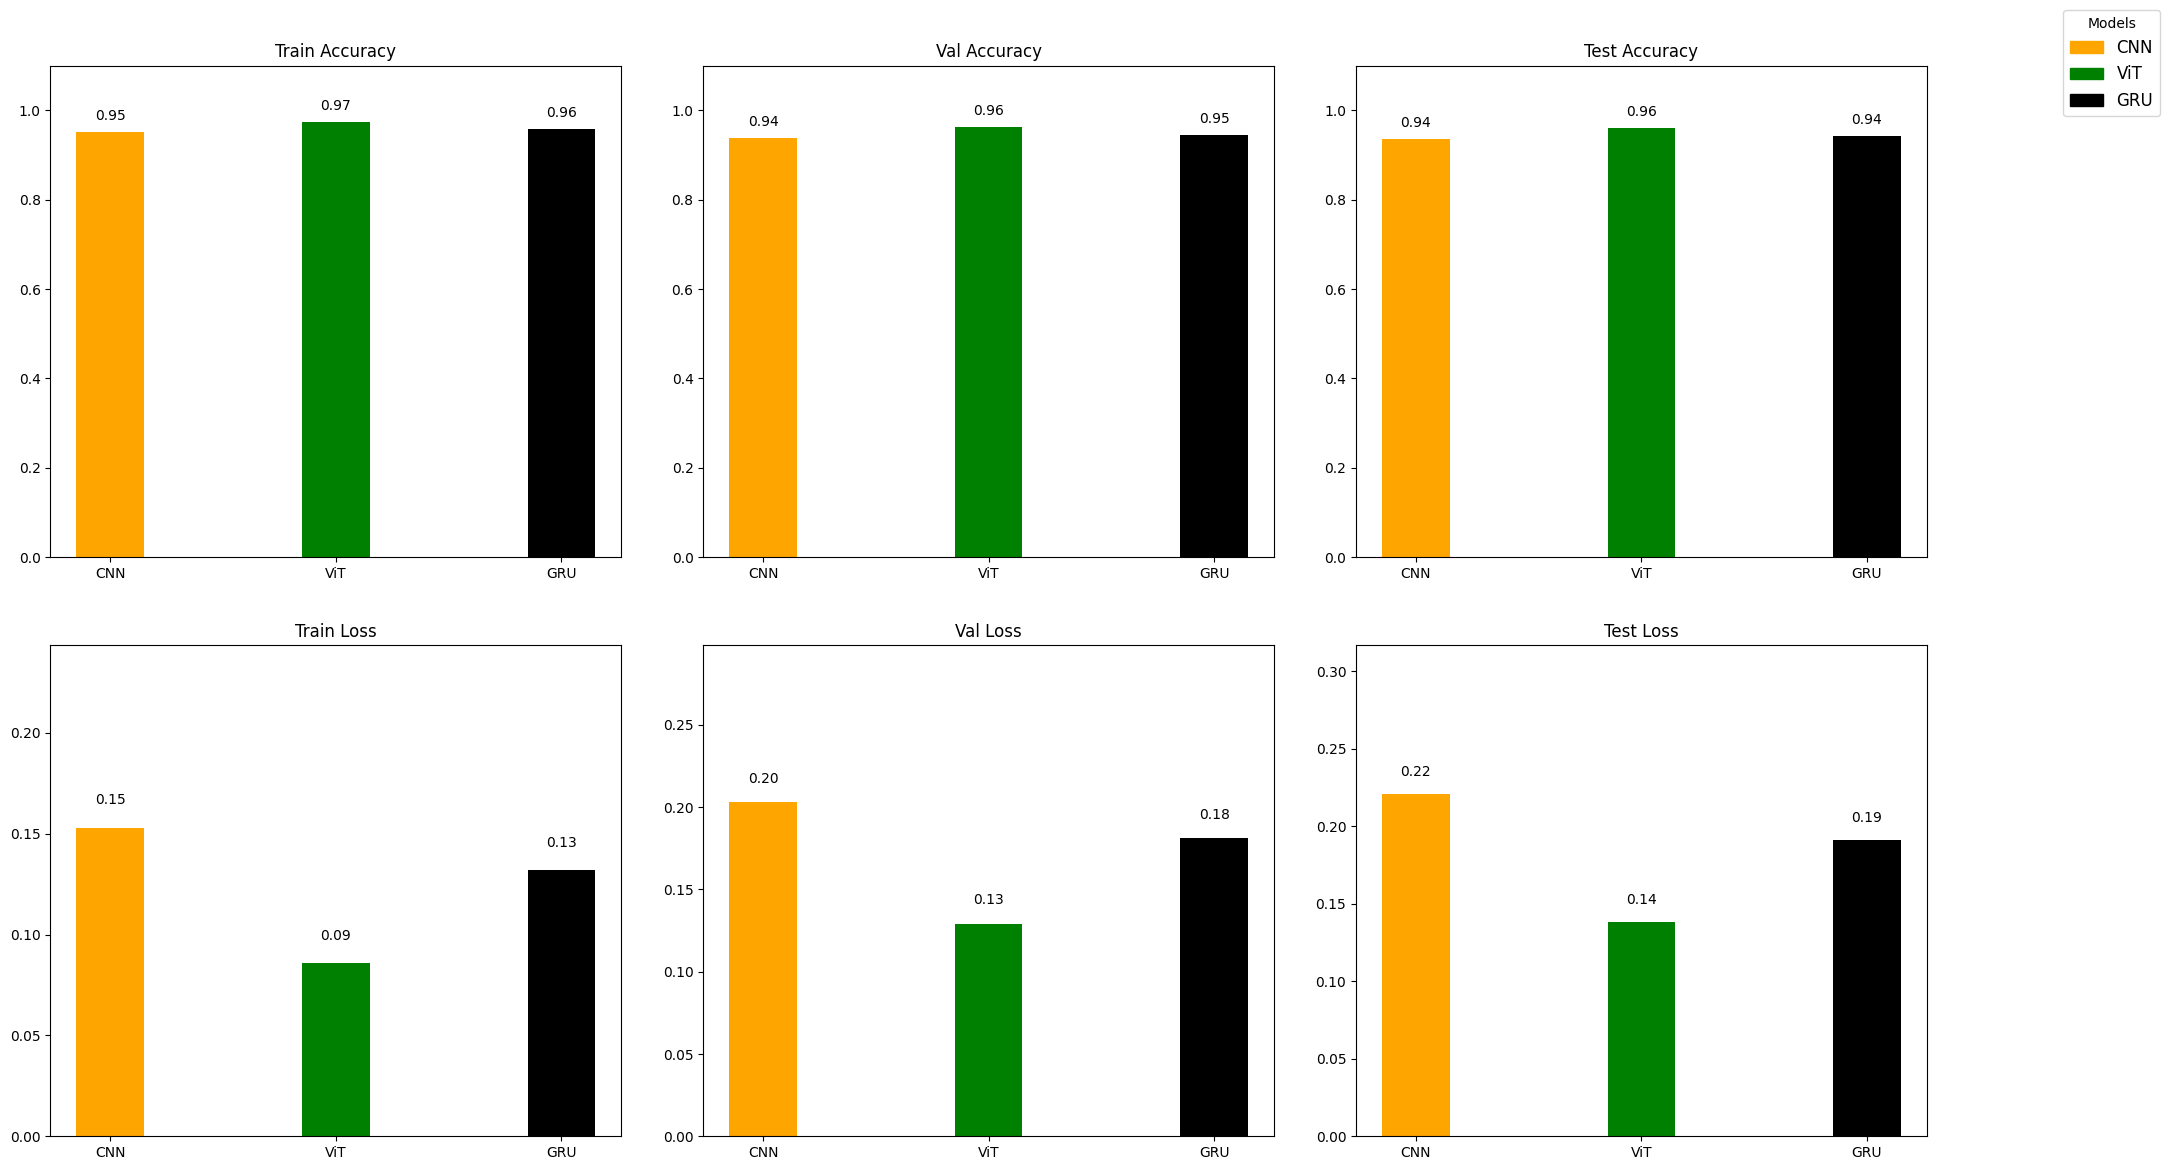

In [27]:
plot_results(all_results)

## Final Average of Results

In [29]:
# Print final average results
def print_final_averages(all_results):
    print("\n" + "="*50)
    print("Final Average Results")
    print("="*50)
    for model in all_results:
        print(f"\n{model} Model:")
        print(f"Train Accuracy: {np.mean(all_results[model]['train_acc']):.4f}")
        print(f"Val Accuracy: {np.mean(all_results[model]['val_acc']):.4f}")
        print(f"Test Accuracy: {np.mean(all_results[model]['test_acc']):.4f}")
        print(f"Train Loss: {np.mean(all_results[model]['train_loss']):.4f}")
        print(f"Val Loss: {np.mean(all_results[model]['val_loss']):.4f}")
        print(f"Test Loss: {np.mean(all_results[model]['test_loss']):.4f}")

In [30]:
print_final_averages(all_results)


Final Average Results

CNN Model:
Train Accuracy: 0.9506
Val Accuracy: 0.9375
Test Accuracy: 0.9359
Train Loss: 0.1530
Val Loss: 0.2032
Test Loss: 0.2206

ViT Model:
Train Accuracy: 0.9735
Val Accuracy: 0.9626
Test Accuracy: 0.9601
Train Loss: 0.0858
Val Loss: 0.1293
Test Loss: 0.1381

GRU Model:
Train Accuracy: 0.9576
Val Accuracy: 0.9456
Test Accuracy: 0.9433
Train Loss: 0.1319
Val Loss: 0.1813
Test Loss: 0.1908
